In [5]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re

with open('.server') as f:
    url = f.readline().strip()
path = f"{url}/flights.csv"

In [6]:
# Define the mapping dictionary
name_mapping = {
    'ماهان': 'Mahan',
    'آتا': 'ATA',
    'وارش': 'Varesh',
    'ساها': 'Saha',
    'معراج': 'Meraj',
    'آسمان': 'Aseman',
    'ایران ایر': 'Iran Air',
    'قدر ایر': 'Ghadr Air',
    'کیش ایر': 'Kish Air',
    'کاسپین': 'Caspian',
    'کارون': 'Karun',
    'ایران ایرتور': 'Iran Airtour',
    'پويا': 'Pouya',
    'قشم ایر': 'Qeshm Air',
    'فلای پرشیا': 'Fly Persia',
    'آساجت': 'ASA',
    'تابان': 'Taban',
    'زاگرس': 'Zagros',
    'چابهار': 'Chabahar',
    'سپهران': 'Sepehran',
    'پارس ایر': 'Pars Air',
    'اروان': 'Arvan',
    'هواپیمایی پارس': 'Pars Airlines'
}

def calc_delay(formal_time, real_time):
    if not formal_time or not real_time:
        return None

    # Regular expression to extract time in HH:MM or HH:MM:SS format
    pattern = re.compile(r'(\d{2}:\d{2}(:\d{2})?)')

    # Extract times
    formal_match = pattern.search(formal_time)
    real_match = pattern.search(real_time)

    if not formal_match or not real_match:
        #logger.warning(f"Couldn't find a valid time in either '{formal_time}' or '{real_time}'")
        return None  # Couldn't find a valid time

    formal_time_str = formal_match.group(1)
    real_time_str = real_match.group(1)

    # If the extracted time is in HH:MM format
    if len(real_time_str) == 5:
        real_datetime = datetime.strptime(real_time_str, '%H:%M')
    # If the extracted time is in HH:MM:SS format
    else:
        real_datetime = datetime.strptime(real_time_str, '%H:%M:%S')

    formal_datetime = datetime.strptime(formal_time_str, '%H:%M')
    
    # Check if real_datetime is more than 12 hour before formal_datetime and adjust for next day
    if (formal_datetime - real_datetime).total_seconds() > 12 * 60 * 60:
        return (real_datetime + timedelta(days=1) - formal_datetime).total_seconds() // 60

    return (real_datetime - formal_datetime).total_seconds() // 60

# Test the function with the provided outlier data
test_data = [
    ("پنج شنبه 23:50", "1402-07-14 00:16"),
    ("پنج شنبه 23:45", "1402-07-14 00:50"),
    ("پنج شنبه 23:55", "1402-07-14 01:20"),
    ("پنج شنبه 23:55", "1402-07-14 23:56"),
]


test_results = [calc_delay(formal_time, real_time) for formal_time, real_time in test_data]
test_results

[26.0, 65.0, 85.0, 1.0]

In [7]:
# Apply the corrected calc_delay function to the dataset
flights = pd.read_csv(path)
flights['flight_delay'] = flights.apply(
    lambda row: calc_delay(row['flight_official_date'], row['flight_real_date']), axis=1)
flights['flight_airline'] = flights['flight_airline'].map(lambda x: name_mapping[x] if x in name_mapping else x)
flights

,flight_origin,flight_destination,flight_airline,flight_official_date,flight_number,flight_status,flight_real_date,flight_delay
0,Mehrabad,مشهد,Mahan,پنج شنبه 00:30,IRM1037,پرواز كرد,1402-07-13 00:53,23.0
1,Mehrabad,اهواز,ATA,پنج شنبه 04:25,TBZ5627,پرواز كرد,1402-07-13 04:41,16.0
2,Mehrabad,تبریز,ATA,پنج شنبه 04:45,TBZ5610,پرواز كرد,1402-07-13 05:20,35.0
3,Mehrabad,مشهد,Varesh,پنج شنبه 05:10,VRH5818,پرواز كرد,1402-07-13 05:23,13.0
4,Mehrabad,لاوان,Saha,پنج شنبه 05:15,IRZ160,پرواز كرد,1402-07-13 05:36,21.0
...,...,...,...,...,...,...,...,...
563,Mashhad,تهران,Iran Airtour,شنبه 20:15,IRB963,پرواز كرد,1402-07-15 20:34,19.0
564,Mashhad,اصفهان,Varesh,شنبه 20:45,VRH5854,پرواز كرد,1402-07-15 21:07,22.0
565,Ahvaz,تهران,Zagros,شنبه 19:00,IZG4020,پرواز كرد,1402-07-15 19:38,38.0
566,Ahvaz,تهران,Pars Air,شنبه 20:15,PRS4445,پرواز كرد,1402-07-15 20:15,0.0


In [8]:
flights.flight_origin.value_counts()

flight_origin
Mehrabad    398
Mashhad     111
Ahvaz        35
Abadan       11
Sari          7
Gorgan        6
Name: count, dtype: int64

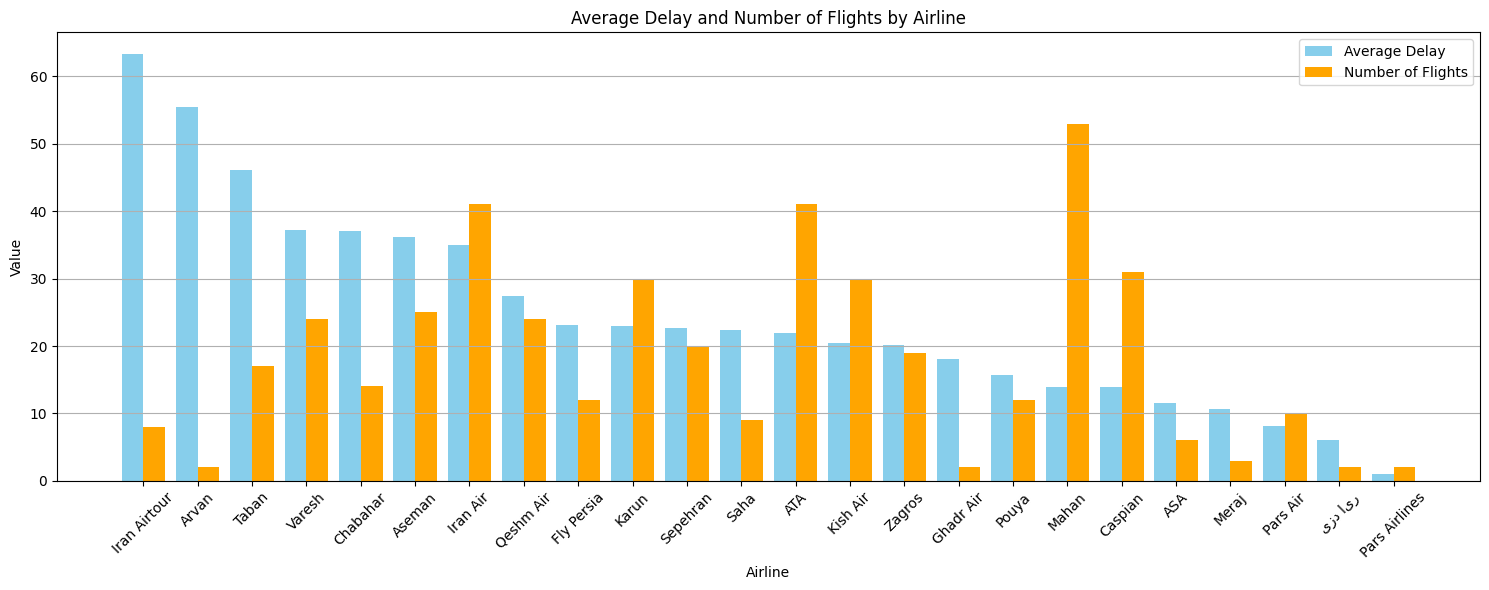

In [4]:
# Group by airline and compute the average delay using the corrected values
average_delays = flights.groupby('flight_airline')['flight_delay'].mean()
number_of_flights = flights.groupby('flight_airline')['flight_delay'].count()

# Combining the average_delays and number_of_flights into a single DataFrame
combined_data = pd.DataFrame({
    'Average Delay': average_delays,
    'Number of Flights': number_of_flights
})

# Sorting the combined data based on the Average Delay
combined_data_sorted = combined_data.sort_values(by='Average Delay', ascending=False)

# Plotting
plt.figure(figsize=(15, 6))

# Create side-by-side bar plots
width = 0.4
x = range(len(combined_data_sorted))
plt.bar(x, combined_data_sorted['Average Delay'], width=width, color='skyblue', label='Average Delay', align='center')
plt.bar([i + width for i in x], combined_data_sorted['Number of Flights'], width=width, color='orange', label='Number of Flights', align='center')

# Setting labels and title
plt.title('Average Delay and Number of Flights by Airline')
plt.ylabel('Value')
plt.xlabel('Airline')
plt.xticks(ticks=[i + width / 2 for i in x], labels=combined_data_sorted.index, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

plt.show()